### Выгрузка из Clickhouse, анализ ARPU и RR по месячным\недельным\дневным когортам

#  Оглавление  
  
1. [Выгрузка данных](#выгрузка)  
2. [Предобработка](#предобработка)  
3. [Анализ ARPU, RR](#анализ)  
    3.1. [По месяцам](#месяц)  
    3.2. [По неделям](#неделя)  
    3.3. [По дням](#день)  
4. [Вывод](#вывод)  

In [3]:
import clickhouse2pandas as ch2pd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Выгрузка <a name='выгрузка'></a>

In [4]:
db_config = {'user': 'thanos', 
 'pwd': 'show_me_your_data', 
 'host': 'dev-01.aksimemor.me',
 'port': 8123, 
 'db': 'default'} 

In [5]:
connection_string = 'http://{}:{}@{}:{}/{}'.format(
 db_config['user'],
 db_config['pwd'],
 db_config['host'],
 db_config['port'],
 db_config['db'])

In [6]:
def select(sql):
    return ch2pd.select(connection_string, sql)

In [ ]:
sql = ''' select * from default.marvel'''
df = ch2pd.select(connection_string, sql)
ch2pd.select(connection_string, sql).to_csv('D:\\Python_learning\\ПРОЕКТЫ\\test_task\\full_db.csv')

# Предобработка <a name='предобработка'></a>

In [27]:
df = pd.read_csv('D:\\Python_learning\\ПРОЕКТЫ\\test_task\\full_db.csv')

In [28]:
df.shape

(16811210, 15)

In [29]:
df.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16811210 entries, 0 to 16811209
Data columns (total 15 columns):
 #   Column                  Non-Null Count     Dtype  
---  ------                  --------------     -----  
 0   Unnamed: 0              16811210 non-null  int64  
 1   Unnamed: 0.1            16811210 non-null  int64  
 2   Unnamed: 0.1.1          16811210 non-null  int64  
 3   Unnamed: 0.1.1.1        16811210 non-null  int64  
 4   user_id                 16811210 non-null  object 
 5   installed_at            16811210 non-null  object 
 6   created_at              16811210 non-null  object 
 7   day                     16811210 non-null  int64  
 8   country                 16811099 non-null  object 
 9   app_version_short       16811210 non-null  object 
 10  last_time_spent         16811210 non-null  int64  
 11  lifetime_session_count  16811210 non-null  int64  
 12  activity_kind           16811210 non-null  object 
 13  event_name              89247 non-null  

В исходной таблице 16 811 210 строк, пропуски только в стоблце с названием ивента и страны. Даты в столбцах с временем начала сессии\установки переведем в формат даты. Также, для последующего когортного анализа выделим отдельно столбцы с днем\неделей\месяцем установки и сессии. Для поставленной задачи многие столбцы не являются необходимыми, поэтому их удалим, чтобы сократить таблицу. 

In [30]:
df['installed_at'] = pd.to_datetime(df['installed_at'], format = '%Y-%m-%d %H:%M:%S')

In [31]:
df['created_at'] = pd.to_datetime(df['created_at'], format = '%Y-%m-%d %H:%M:%S')

In [32]:
df['created_month'] = df['created_at'].astype('datetime64[M]')

In [33]:
df['created_week'] = df['created_at'].astype('datetime64[W]')

In [34]:
df['created_day'] = df['created_at'].astype('datetime64[D]')

In [35]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
       'user_id', 'installed_at', 'created_at', 'day', 'country',
       'app_version_short', 'last_time_spent', 'lifetime_session_count',
       'activity_kind', 'event_name', 'reporting_revenue', 'created_month',
       'created_week', 'created_day'],
      dtype='object')

In [36]:
df.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1'], axis = 1, inplace = True)

Проверим на наличие дубликатов

In [37]:
df[df.duplicated(keep = False)].sort_values(['user_id', 'created_at']).head(15)

,user_id,installed_at,created_at,day,country,app_version_short,last_time_spent,lifetime_session_count,activity_kind,event_name,reporting_revenue,created_month,created_week,created_day
13713435,0000700f-5b2f-4e21-7ffb-7289e8f4e56a,2020-05-02 11:22:25,2020-05-02 16:25:31,0,ru,2.1.0,1932,2,session,NaN,0.0,2020-05-01,2020-04-30,2020-05-02
15498683,0000700f-5b2f-4e21-7ffb-7289e8f4e56a,2020-05-02 11:22:25,2020-05-02 16:25:31,0,ru,2.1.0,1932,2,session,NaN,0.0,2020-05-01,2020-04-30,2020-05-02
13713436,0000700f-5b2f-4e21-7ffb-7289e8f4e56a,2020-05-02 11:22:25,2020-05-02 17:32:02,0,ru,2.1.0,348,3,session,NaN,0.0,2020-05-01,2020-04-30,2020-05-02
15498684,0000700f-5b2f-4e21-7ffb-7289e8f4e56a,2020-05-02 11:22:25,2020-05-02 17:32:02,0,ru,2.1.0,348,3,session,NaN,0.0,2020-05-01,2020-04-30,2020-05-02
13713437,0000700f-5b2f-4e21-7ffb-7289e8f4e56a,2020-05-02 11:22:25,2020-05-03 05:49:15,0,ru,2.1.0,328,4,session,NaN,0.0,2020-05-01,2020-04-30,2020-05-03
15498685,0000700f-5b2f-4e21-7ffb-7289e8f4e56a,2020-05-02 11:22:25,2020-05-03 05:49:15,0,ru,2.1.0,328,4,session,NaN,0.0,2020-05-01,2020-04-30,2020-05-03
12055440,00007ec1-b4a7-26ab-34ba-8f58c7cd8fd9,2020-04-08 15:33:10,2020-04-11 20:13:54,3,se,1.7.6,1351,2,session,NaN,0.0,2020-04-01,2020-04-09,2020-04-11
12965263,00007ec1-b4a7-26ab-34ba-8f58c7cd8fd9,2020-04-08 15:33:10,2020-04-11 20:13:54,3,se,1.7.6,1351,2,session,NaN,0.0,2020-04-01,2020-04-09,2020-04-11
12055441,00007ec1-b4a7-26ab-34ba-8f58c7cd8fd9,2020-04-08 15:33:10,2020-04-13 22:03:29,5,se,1.7.8,765,3,session,NaN,0.0,2020-04-01,2020-04-09,2020-04-13
12965264,00007ec1-b4a7-26ab-34ba-8f58c7cd8fd9,2020-04-08 15:33:10,2020-04-13 22:03:29,5,se,1.7.8,765,3,session,NaN,0.0,2020-04-01,2020-04-09,2020-04-13


In [38]:
df[df.duplicated(keep = 'first')].shape

(5615182, 14)

В датафрейме оказалось больше 5 миллионов дубликатов, удалим их из таблицы

In [39]:
df.drop_duplicates(keep = 'first', inplace = True)

In [40]:
df.activity_kind.value_counts()

session    11133288
event         62740
Name: activity_kind, dtype: int64

In [41]:
df.event_name.value_counts()

revenue_all    62740
Name: event_name, dtype: int64

In [42]:
df[df.reporting_revenue != 0.0].shape

(62740, 14)

Всего у нас 2 ивента - обычная сессия и "ивент", во время которого, судя по всему, происходит оплата. Соответственно, название ивента указано только непосредственно в строках с ивентами, что объясняет пропуски в остальных строках. 

Посмотрим также, везде ли совпадает кол-во дней в игре с разницей между фактическим временем сессии и датой установки. 

In [43]:
df[df['day'] != (df.created_at - df.installed_at).dt.days]

,user_id,installed_at,created_at,day,country,app_version_short,last_time_spent,lifetime_session_count,activity_kind,event_name,reporting_revenue,created_month,created_week,created_day
14295492,a101a69a-7813-88c0-de0f-36cbc34f3801,2020-04-02 01:21:12,2020-04-02 01:21:09,0,us,1.7.6,0,1,event,revenue_all,2.99,2020-04-01,2020-04-02,2020-04-02


In [44]:
df[df.created_at < df.installed_at]

,user_id,installed_at,created_at,day,country,app_version_short,last_time_spent,lifetime_session_count,activity_kind,event_name,reporting_revenue,created_month,created_week,created_day
14295492,a101a69a-7813-88c0-de0f-36cbc34f3801,2020-04-02 01:21:12,2020-04-02 01:21:09,0,us,1.7.6,0,1,event,revenue_all,2.99,2020-04-01,2020-04-02,2020-04-02


У одного юзера время сессии по какой-то причине зафиксировано раньше времени установки.

In [45]:
df.drop(['day', 'country',
       'app_version_short', 'last_time_spent', 'lifetime_session_count', 'event_name'], axis = 1, inplace = True)

In [46]:
df.head()

,user_id,installed_at,created_at,activity_kind,reporting_revenue,created_month,created_week,created_day
0,dfd3e960-ee31-8b26-90c1-621247d8302c,2020-04-13 12:45:42,2020-06-21 18:25:39,session,0.0,2020-06-01,2020-06-18,2020-06-21
1,dfd3e960-ee31-8b26-90c1-621247d8302c,2020-04-13 12:45:42,2020-06-21 20:57:19,session,0.0,2020-06-01,2020-06-18,2020-06-21
2,dfd3e960-ee31-8b26-90c1-621247d8302c,2020-04-13 12:45:42,2020-06-22 13:18:58,session,0.0,2020-06-01,2020-06-18,2020-06-22
3,dfd3e960-ee31-8b26-90c1-621247d8302c,2020-04-13 12:45:42,2020-06-22 22:05:52,session,0.0,2020-06-01,2020-06-18,2020-06-22
4,dfd3e960-ee31-8b26-90c1-621247d8302c,2020-04-13 12:45:42,2020-06-23 07:41:50,session,0.0,2020-06-01,2020-06-18,2020-06-23


In [47]:
df.installed_at.min()

Timestamp('2019-12-16 08:33:30')

In [48]:
df.installed_at.max()

Timestamp('2020-07-01 23:16:03')

Временной промежуток таблицы - с 16 декабря 2019 года по 01 июля 2020 года.

Проверим дату установки

In [49]:
(df.groupby('user_id')['installed_at'].nunique() > 1).value_counts()

False    1454249
True          84
Name: installed_at, dtype: int64

У 84 пользователей есть более 1 зафиксированной даты установки. Возможно, они удаляли и заново скачивали игру. 

In [50]:
df[df.reporting_revenue != 0]['reporting_revenue'].describe()

count    62740.000000
mean         9.036146
std          7.932318
min          1.512512
25%          4.990000
50%          7.758103
75%         10.990000
max         66.210210
Name: reporting_revenue, dtype: float64

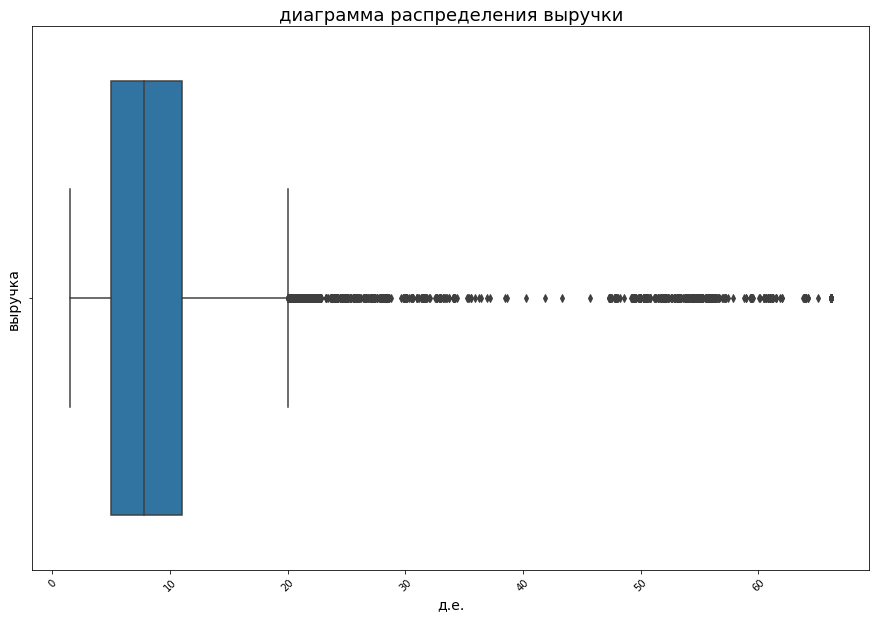

In [51]:
fig, ax = plt.subplots(figsize=(15,10))

sns.boxplot(x='reporting_revenue',  data=df[df.reporting_revenue != 0])

ax.set_xlabel('д.е.', fontsize=14)
ax.set_ylabel('выручка', fontsize=14)
plt.xticks(rotation=45)
ax.set_title('диаграмма распределения выручки', fontsize=18)
plt.show()

In [52]:
np.percentile(df[df.reporting_revenue != 0]['reporting_revenue'], [95, 99])

array([21.1392726, 52.100292 ])

In [53]:
df[df.reporting_revenue >21].shape

(3181, 8)

95% оплат находятся в диапазоне до 21 д.е., но есть и события, когда было потрачено до 60 д.е. 

# Когортный анализ ARPU и Retention Rate <a name='анализ'></a>

### По месяцам <a name='месяц'></a>

Выделим месяц первой сессии для каждого пользователя. Стоит отметить, что есть пользователи, у которых есть большой промежуток между датой установки и датой первой сессии. Но За первоначальную дату будем брать именно первую сессию, т.к. это первое знакомство пользователя с продуктом.

In [54]:
first_month = df.groupby(['user_id'])['created_month'].min()

In [55]:
first_month.head()

user_id
00000d13-a60b-d8a5-372c-6ac3338d9532   2020-05-01
000021ca-20bf-8f73-7298-88d4091c0b43   2020-04-01
00003734-81ef-7a1d-e4c9-f984bf2bc8bc   2020-05-01
00004cea-3621-30ef-db24-1e52d001449b   2020-04-01
00005b7d-52a7-2280-be8e-a932155dd075   2020-06-01
Name: created_month, dtype: datetime64[ns]

In [56]:
first_month.name = 'first_month'

In [57]:
#добавляем его столбцом к основной таблице
df = df.join(first_month,on='user_id') 

In [58]:
#считаем, сколько месяцев прошло на момент каждой сессии
df['lifetime'] = (df['created_month'] - df['first_month']) / np.timedelta64(1,'M')
df['lifetime'] = df['lifetime'].apply(np.round).astype('int64')

In [59]:
df.head()

,user_id,installed_at,created_at,activity_kind,reporting_revenue,created_month,created_week,created_day,first_month,lifetime
0,dfd3e960-ee31-8b26-90c1-621247d8302c,2020-04-13 12:45:42,2020-06-21 18:25:39,session,0.0,2020-06-01,2020-06-18,2020-06-21,2020-04-01,2
1,dfd3e960-ee31-8b26-90c1-621247d8302c,2020-04-13 12:45:42,2020-06-21 20:57:19,session,0.0,2020-06-01,2020-06-18,2020-06-21,2020-04-01,2
2,dfd3e960-ee31-8b26-90c1-621247d8302c,2020-04-13 12:45:42,2020-06-22 13:18:58,session,0.0,2020-06-01,2020-06-18,2020-06-22,2020-04-01,2
3,dfd3e960-ee31-8b26-90c1-621247d8302c,2020-04-13 12:45:42,2020-06-22 22:05:52,session,0.0,2020-06-01,2020-06-18,2020-06-22,2020-04-01,2
4,dfd3e960-ee31-8b26-90c1-621247d8302c,2020-04-13 12:45:42,2020-06-23 07:41:50,session,0.0,2020-06-01,2020-06-18,2020-06-23,2020-04-01,2


Теперь сгруппируем когорты по месяцам и посчитаем, сколько было уникальных пользователей и прибыли на каждый последующий месяц 

In [60]:
cohorts = df.groupby(['first_month','lifetime']).agg({'user_id':'nunique', 'reporting_revenue' : 'sum'}).reset_index() 

In [61]:
cohorts.head()

,first_month,lifetime,user_id,reporting_revenue
0,2020-01-01,0,329,22477.865528
1,2020-01-01,1,24,554.364743
2,2020-01-01,2,7,1616.484395
3,2020-01-01,3,6,780.803756
4,2020-01-01,4,14,613.151957


Проверяем, сходятся ли данные по прибыли после произведенных операций

In [62]:
def revenue_check(data, cohort_data):
    diff = data['reporting_revenue'].sum().round() - cohort_data['reporting_revenue'].sum().round()
    if diff == 0:
        print('все сходится')
    else:
        print('разница составляет: {}'.format(diff))

In [63]:
revenue_check(df, cohorts)

все сходится


In [64]:
#округляем
cohorts['reporting_revenue'] = cohorts['reporting_revenue'].apply(lambda x:round(x,2))

In [65]:
cohorts.head()

,first_month,lifetime,user_id,reporting_revenue
0,2020-01-01,0,329,22477.87
1,2020-01-01,1,24,554.36
2,2020-01-01,2,7,1616.48
3,2020-01-01,3,6,780.80
4,2020-01-01,4,14,613.15


Отдельно считаем, сколько вообще пользователей в каждой когорте. Т.е. общее кол-во человек, который зашли в игру в определенный месяц. И добавляем это столбцом к предыдущей таблице

In [66]:
cohort_users = df.groupby(['first_month']).agg({'user_id':'nunique'}).reset_index()

In [67]:
cohort_users.head()

,first_month,user_id
0,2020-01-01,329
1,2020-02-01,5232
2,2020-03-01,77526
3,2020-04-01,542851
4,2020-05-01,485144


In [68]:
cohort_users['user_id'].sum() - df['user_id'].nunique()

0

In [69]:
cohort_users = cohort_users.rename(columns={'user_id':'cohort_users'}) 

In [70]:
cohorts = cohorts.merge(cohort_users,on='first_month')

Теперь можно посчитать целевые метрики.  
ARPU , отношение полученной прибыли к кол-ву пользователей  
Retention Rate , отношение кол-ва уникальных пользователей в определенный месяц лайфтайм к общему числу пользователей в когорте.

In [71]:
cohorts['retention'] = cohorts['user_id']/cohorts['cohort_users'] 

In [72]:
cohorts['arpu'] = cohorts.reporting_revenue / cohorts.cohort_users

In [73]:
cohorts.head()

,first_month,lifetime,user_id,reporting_revenue,cohort_users,retention,arpu
0,2020-01-01,0,329,22477.87,329,1.000000,68.321793
1,2020-01-01,1,24,554.36,329,0.072948,1.684985
2,2020-01-01,2,7,1616.48,329,0.021277,4.913313
3,2020-01-01,3,6,780.80,329,0.018237,2.373252
4,2020-01-01,4,14,613.15,329,0.042553,1.863678


In [74]:
cohorts['retention'] = cohorts['retention'].apply(lambda x:round(x,2))

In [75]:
cohorts['arpu'] = cohorts['arpu'].apply(lambda x:round(x,2))

In [76]:
#строим сводную таблицу по каждой когорте
retention_pivot = cohorts.pivot_table(index='first_month',columns='lifetime',values='retention',aggfunc='sum')

In [77]:
retention_pivot

lifetime,0,1,2,3,4,5
first_month,,,,,,
2020-01-01,1.0,0.07,0.02,0.02,0.04,0.04
2020-02-01,1.0,0.08,0.02,0.03,0.03,0.00
2020-03-01,1.0,0.45,0.09,0.04,0.00,NaN
2020-04-01,1.0,0.22,0.06,0.00,NaN,NaN
2020-05-01,1.0,0.19,0.01,NaN,NaN,NaN
2020-06-01,1.0,0.08,NaN,NaN,NaN,NaN
2020-07-01,1.0,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:title={'center':'Monthly Retention Rate'}, xlabel='lifetime', ylabel='first_month'>

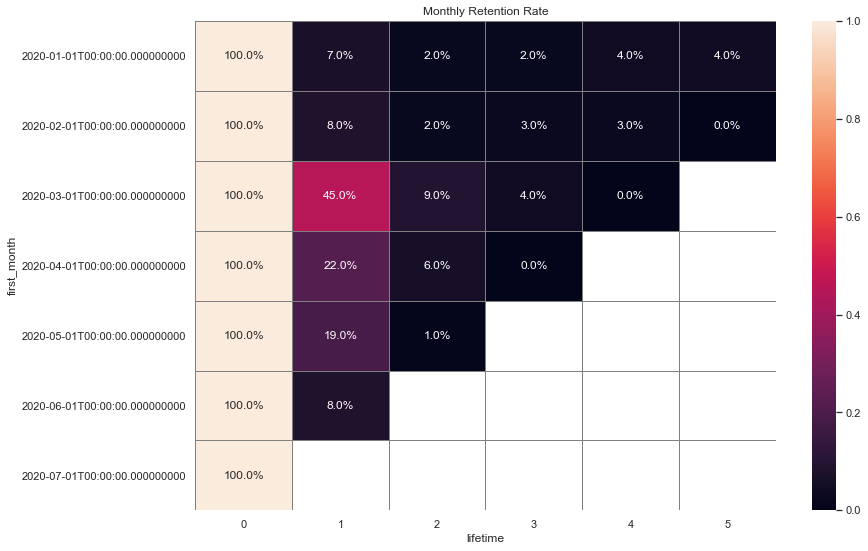

In [79]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Monthly Retention Rate')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmin = 0.0, vmax = 1)

Январская и февральская когорты показывали маленькую возвращаемость, но в марте, возможно, что-то было доработано и начиная с мартовской когорты пользователи стали охотнее возвращаться в следующем месяце. Хотя, со временем эта цифра тоже падает и возвращается на уровень января-февраля.

In [80]:
arpu_pivot = cohorts.pivot_table(index='first_month',columns='lifetime',values='arpu',aggfunc='sum')

In [81]:
arpu_pivot

lifetime,0,1,2,3,4,5
first_month,,,,,,
2020-01-01,68.32,1.68,4.91,2.37,1.86,1.12
2020-02-01,12.08,1.62,0.36,0.58,0.70,0.01
2020-03-01,1.03,0.11,0.06,0.05,0.00,NaN
2020-04-01,0.15,0.03,0.01,0.00,NaN,NaN
2020-05-01,0.18,0.05,0.00,NaN,NaN,NaN
2020-06-01,0.45,0.01,NaN,NaN,NaN,NaN
2020-07-01,0.14,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:title={'center':'Monthly ARPU'}, xlabel='lifetime', ylabel='first_month'>

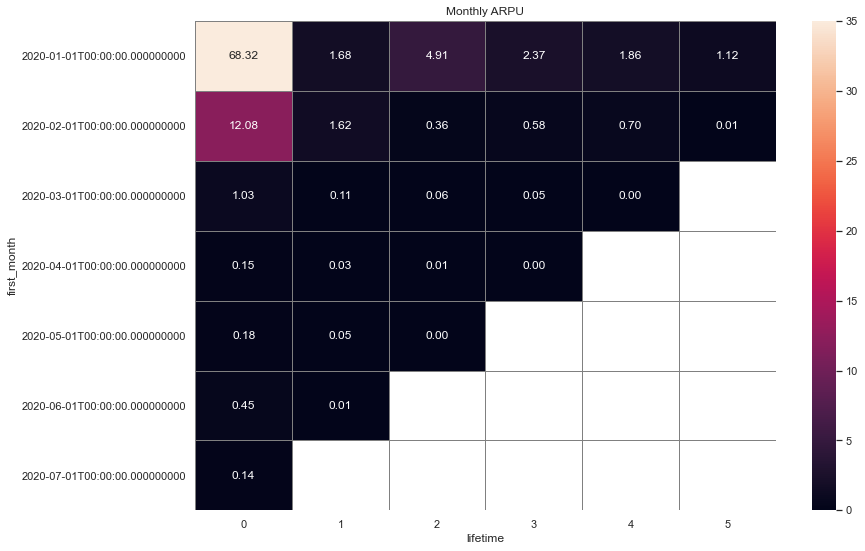

In [82]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Monthly ARPU')
sns.heatmap(arpu_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray', vmin = 0.0, vmax = 35)

По ARPU первая когорта показала хорошее значение 68.32 д.е. на пользователя в первый месяц. Февральская когорта уже значительно сбавила, а остальные когорты показывают уже показатель, стремящийся к 0 вне зависимости от месяца лайфтайма. Это может быть связано с увеличением числа пользователей \ уменьшением суммы покупок, уменьшением кол-ва платящих пользователей 

Также можно посчитать накопительный ARPU

In [83]:
arpu_pivot_sum = arpu_pivot.cumsum(axis=1)
arpu_pivot_sum

lifetime,0,1,2,3,4,5
first_month,,,,,,
2020-01-01,68.32,70.00,74.91,77.28,79.14,80.26
2020-02-01,12.08,13.70,14.06,14.64,15.34,15.35
2020-03-01,1.03,1.14,1.20,1.25,1.25,NaN
2020-04-01,0.15,0.18,0.19,0.19,NaN,NaN
2020-05-01,0.18,0.23,0.23,NaN,NaN,NaN
2020-06-01,0.45,0.46,NaN,NaN,NaN,NaN
2020-07-01,0.14,NaN,NaN,NaN,NaN,NaN


In [84]:
cumulative_revenue = (df.groupby(['first_month','lifetime']).agg({'reporting_revenue' : 'sum'}) \
                      .groupby(level=0).cumsum().reset_index().merge(cohort_users,on='first_month'))
cumulative_revenue.head()

,first_month,lifetime,reporting_revenue,cohort_users
0,2020-01-01,0,22477.865528,329
1,2020-01-01,1,23032.230271,329
2,2020-01-01,2,24648.714666,329
3,2020-01-01,3,25429.518421,329
4,2020-01-01,4,26042.670379,329


In [85]:
cumulative_revenue['cumulative_arpu'] = cumulative_revenue.reporting_revenue / cumulative_revenue.cohort_users

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


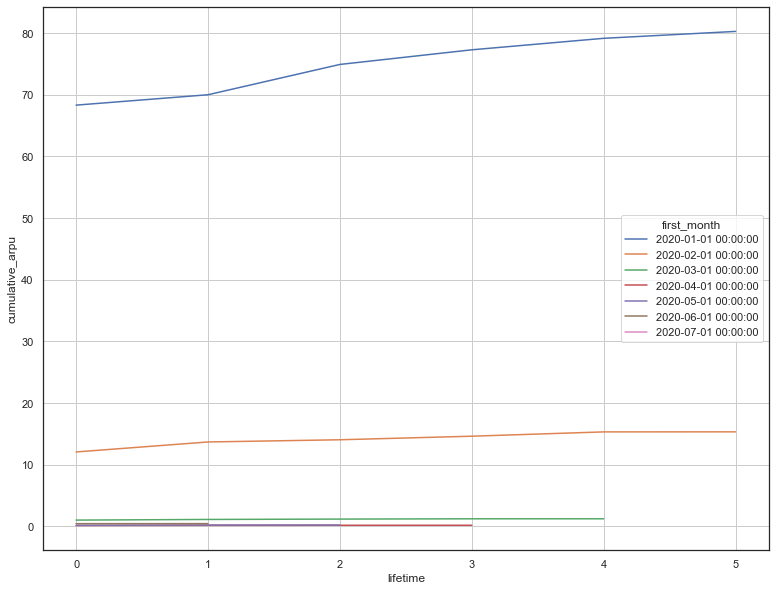

In [86]:
fig, ax = plt.subplots()
fig.set_figheight(10) 
fig.set_figwidth(13)
ax = sns.lineplot(cumulative_revenue['lifetime'], cumulative_revenue['cumulative_arpu'], hue = cumulative_revenue['first_month'])
ax.grid(True)
plt.show()

в целом, на второй месяц графики выходят на стабильный уровень

Посмотрим на кол-во пользователей по когортам и их соотношение с теми юзерами, которые совершают покупки

In [87]:
paying_users = df.groupby(['first_month', 'user_id'])['reporting_revenue'].sum().reset_index()
paying_users = paying_users[paying_users.reporting_revenue != 0]

In [88]:
revenue_check(paying_users, df)

все сходится


In [89]:
cohort_users = (cohort_users.merge 
                (paying_users.groupby('first_month')['user_id'].count()  
                 .rename('paying_users').reset_index(), on = 'first_month')
                .merge(cohorts.groupby('first_month')['reporting_revenue'].sum().reset_index(), on = 'first_month'))
cohort_users

,first_month,cohort_users,paying_users,reporting_revenue
0,2020-01-01,329,329,26411.38
1,2020-02-01,5232,5232,80256.82
2,2020-03-01,77526,6948,96046.39
3,2020-04-01,542851,6019,102018.78
4,2020-05-01,485144,6015,109847.30
5,2020-06-01,330513,6358,150616.84
6,2020-07-01,12738,102,1730.27


Видно, что кол-во пользователей существенно возростало и достигло пика в апреле, а далее опять пошло на убыль

In [91]:
#проверяем, сходится ли кол-во 
df[df.reporting_revenue != 0]['user_id'].nunique() - cohort_users.paying_users.sum()

0

In [92]:
cohort_users['paying_pct'] = cohort_users.paying_users / cohort_users.cohort_users

In [93]:
cohort_users['arppu'] = cohort_users.reporting_revenue / cohort_users.paying_users
cohort_users

,first_month,cohort_users,paying_users,reporting_revenue,paying_pct,arppu
0,2020-01-01,329,329,26411.38,1.000000,80.277751
1,2020-02-01,5232,5232,80256.82,1.000000,15.339606
2,2020-03-01,77526,6948,96046.39,0.089622,13.823602
3,2020-04-01,542851,6019,102018.78,0.011088,16.949457
4,2020-05-01,485144,6015,109847.30,0.012398,18.262228
5,2020-06-01,330513,6358,150616.84,0.019237,23.689343
6,2020-07-01,12738,102,1730.27,0.008008,16.963431


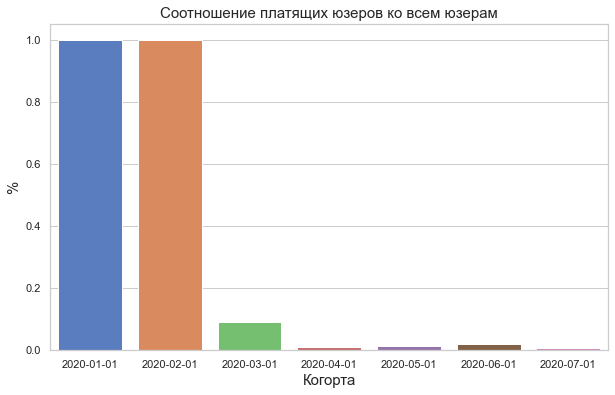

In [94]:
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x = cohort_users.first_month.astype('str'), y = cohort_users.paying_pct, data=cohort_users, ci=None, palette="muted",orient='v' )
ax.set_title("Соотношение платящих юзеров ко всем юзерам", fontsize=15)
ax.set_xlabel ("Когорта", fontsize=15)
ax.set_ylabel ("%", fontsize=15)
plt.show()


При этом, первые две когорты стабильно совершали покупки, а в следующих когортах кол-во платящих пользователей оставалось +- на уровне февральской когорты (в районе 6 тысяч) при многократном увеличении общего кол-ва пользователей. 

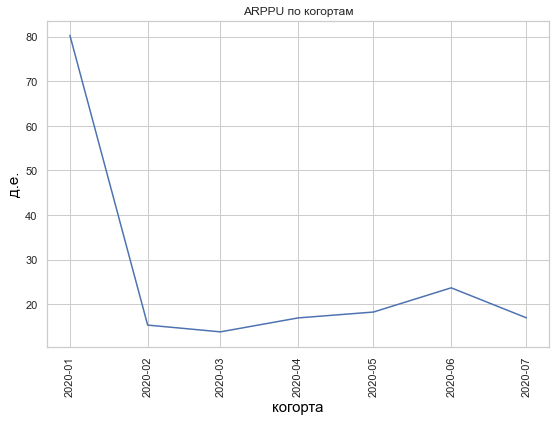

In [95]:
fig, ax = plt.subplots()
fig.set_figheight(6) 
fig.set_figwidth(9) 
ax.plot(cohort_users.first_month, cohort_users.arppu)
ax.set_xlabel('когорта', fontsize = 15, color = 'black')
ax.set_ylabel('д.е.', fontsize = 15, color = 'black')
plt.xticks(rotation=90)
ax.grid(True)
ax.set_title('ARPPU по когортам')
plt.show()

## По неделям <a name='неделя'></a>

In [96]:
first_week = df.groupby(['user_id'])['created_week'].min()

In [97]:
first_week.head()

user_id
00000d13-a60b-d8a5-372c-6ac3338d9532   2020-04-30
000021ca-20bf-8f73-7298-88d4091c0b43   2020-04-02
00003734-81ef-7a1d-e4c9-f984bf2bc8bc   2020-04-30
00004cea-3621-30ef-db24-1e52d001449b   2020-04-02
00005b7d-52a7-2280-be8e-a932155dd075   2020-06-18
Name: created_week, dtype: datetime64[ns]

In [98]:
first_week.name = 'first_week'

In [99]:
df = df.join(first_week,on='user_id') 

In [100]:
df['lifetime_week'] = (df['created_week'] - df['first_week']) / np.timedelta64(1,'W')

In [101]:
df['lifetime_week'] = df['lifetime_week'].apply(np.round).astype('int64')

In [102]:
df.head()

,user_id,installed_at,created_at,activity_kind,reporting_revenue,created_month,created_week,created_day,first_month,lifetime,first_week,lifetime_week
0,dfd3e960-ee31-8b26-90c1-621247d8302c,2020-04-13 12:45:42,2020-06-21 18:25:39,session,0.0,2020-06-01,2020-06-18,2020-06-21,2020-04-01,2,2020-04-09,10
1,dfd3e960-ee31-8b26-90c1-621247d8302c,2020-04-13 12:45:42,2020-06-21 20:57:19,session,0.0,2020-06-01,2020-06-18,2020-06-21,2020-04-01,2,2020-04-09,10
2,dfd3e960-ee31-8b26-90c1-621247d8302c,2020-04-13 12:45:42,2020-06-22 13:18:58,session,0.0,2020-06-01,2020-06-18,2020-06-22,2020-04-01,2,2020-04-09,10
3,dfd3e960-ee31-8b26-90c1-621247d8302c,2020-04-13 12:45:42,2020-06-22 22:05:52,session,0.0,2020-06-01,2020-06-18,2020-06-22,2020-04-01,2,2020-04-09,10
4,dfd3e960-ee31-8b26-90c1-621247d8302c,2020-04-13 12:45:42,2020-06-23 07:41:50,session,0.0,2020-06-01,2020-06-18,2020-06-23,2020-04-01,2,2020-04-09,10


Теперь сгруппируем когорты по неделям и посчитаем, сколько было уникальных пользователей и прибыли на каждый последующий месяц 

In [103]:
cohorts_week = df.groupby(['first_week','lifetime_week']).agg({'user_id':'nunique', 'reporting_revenue' : 'sum'}).reset_index() 

In [104]:
cohorts_week.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   first_week         286 non-null    datetime64[ns]
 1   lifetime_week      286 non-null    int64         
 2   user_id            286 non-null    int64         
 3   reporting_revenue  286 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 9.1 KB


In [105]:
cohorts_week.head()

,first_week,lifetime_week,user_id,reporting_revenue
0,2020-01-16,0,5,167.920134
1,2020-01-16,1,2,886.739600
2,2020-01-16,2,1,7.040320
3,2020-01-16,3,2,9.035225
4,2020-01-16,4,2,25.575353


Проверяем, сходятся ли данные по прибыли после произведенных операций

In [106]:
revenue_check(df, cohorts_week)

все сходится


In [107]:
cohorts_week['reporting_revenue'] = cohorts_week['reporting_revenue'].apply(lambda x:round(x,2))

In [108]:
cohorts_week.head()

,first_week,lifetime_week,user_id,reporting_revenue
0,2020-01-16,0,5,167.92
1,2020-01-16,1,2,886.74
2,2020-01-16,2,1,7.04
3,2020-01-16,3,2,9.04
4,2020-01-16,4,2,25.58


In [109]:
cohorts_week.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   first_week         286 non-null    datetime64[ns]
 1   lifetime_week      286 non-null    int64         
 2   user_id            286 non-null    int64         
 3   reporting_revenue  286 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 9.1 KB


In [110]:
cohort_week_users = df.groupby(['first_week']).agg({'user_id':'nunique'}).reset_index()

In [111]:
cohort_week_users.head()

,first_week,user_id
0,2020-01-16,5
1,2020-01-23,247
2,2020-01-30,568
3,2020-02-06,849
4,2020-02-13,1285


In [112]:
cohort_week_users = cohort_week_users.rename(columns={'user_id':'cohort_week_users'}) 

In [113]:
cohorts_week = cohorts_week.merge(cohort_week_users,on='first_week')

In [114]:
cohorts_week['retention'] = cohorts_week['user_id']/cohorts_week['cohort_week_users'] 

In [115]:
cohorts_week['arpu'] = cohorts_week.reporting_revenue / cohorts_week.cohort_week_users

In [116]:
cohorts_week.head()

,first_week,lifetime_week,user_id,reporting_revenue,cohort_week_users,retention,arpu
0,2020-01-16,0,5,167.92,5,1.0,33.584
1,2020-01-16,1,2,886.74,5,0.4,177.348
2,2020-01-16,2,1,7.04,5,0.2,1.408
3,2020-01-16,3,2,9.04,5,0.4,1.808
4,2020-01-16,4,2,25.58,5,0.4,5.116


In [117]:
cohorts_week['retention'] = cohorts_week['retention'].apply(lambda x:round(x,2))

In [118]:
cohorts_week['arpu'] = cohorts_week['arpu'].apply(lambda x:round(x,2))

In [119]:
retention_week_pivot = cohorts_week.pivot_table(index='first_week',columns='lifetime_week',values='retention',aggfunc='sum')

In [120]:
rtv = retention_week_pivot.set_index(cohorts_week.first_week.unique())
rtv.index = rtv.index.astype('str')

<AxesSubplot:title={'center':'Weekly Retention Rate'}, xlabel='lifetime_week'>

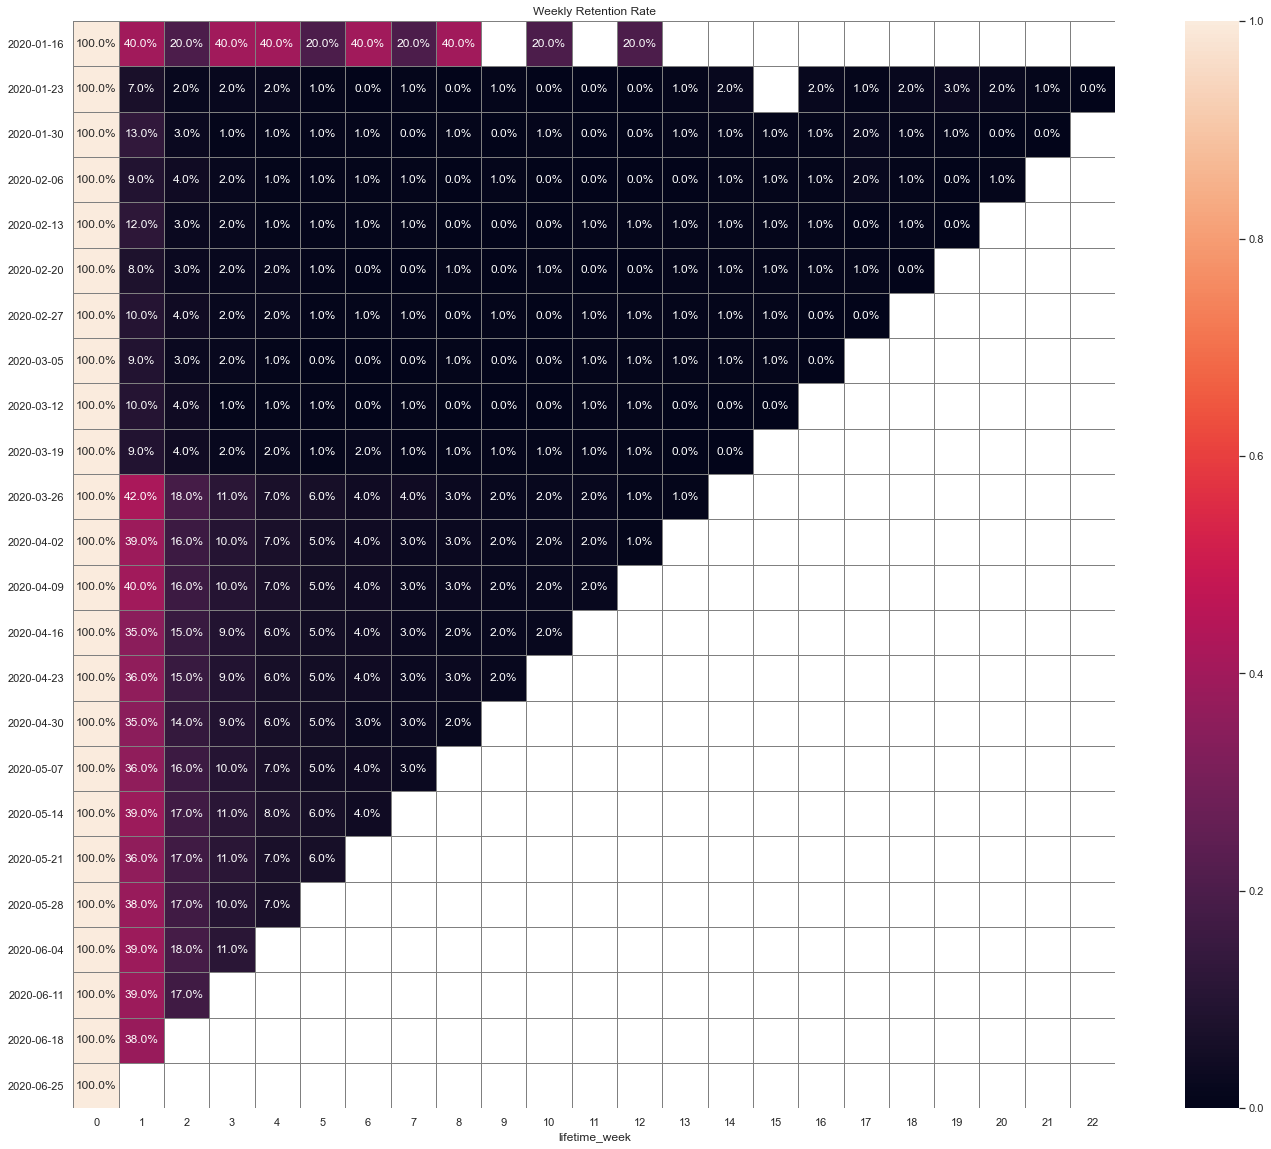

In [121]:
sns.set(style='white')
plt.figure(figsize=(25, 20))
plt.title('Weekly Cohorts Retention Rate')
sns.heatmap(rtv, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmin = 0.0, vmax = 1, square=True)


В разбивке по неделям так же видим, что пользователи лишь из первой когорты дольше проявляли интерес и возвращались, затем относительное затишье, лишь 10% юзеров возвращались в течение второй недели. А с конца марта во вторую неделю стали возвращаться уже 30-40%. 15-20% удавалось удержать и в течение третьей недели. Примечательно, что всплеск совпадает с введением карантина. Возможно, это как-то повлияло на интерес к игре. 

In [122]:
arpu_week_pivot = cohorts_week.pivot_table(index='first_week',columns='lifetime_week',values='arpu',aggfunc='sum')

In [123]:
arpu_week_pivot.index = arpu_week_pivot.index.astype('str')

In [124]:
cohorts_week

,first_week,lifetime_week,user_id,reporting_revenue,cohort_week_users,retention,arpu
0,2020-01-16,0,5,167.92,5,1.00,33.58
1,2020-01-16,1,2,886.74,5,0.40,177.35
2,2020-01-16,2,1,7.04,5,0.20,1.41
3,2020-01-16,3,2,9.04,5,0.40,1.81
4,2020-01-16,4,2,25.58,5,0.40,5.12
...,...,...,...,...,...,...,...
281,2020-06-11,1,32745,9192.85,84106,0.39,0.11
282,2020-06-11,2,14515,2425.63,84106,0.17,0.03
283,2020-06-18,0,73202,26219.33,73202,1.00,0.36
284,2020-06-18,1,27743,5864.79,73202,0.38,0.08


<AxesSubplot:title={'center':'Weekly ARPU'}, xlabel='lifetime_week', ylabel='first_week'>

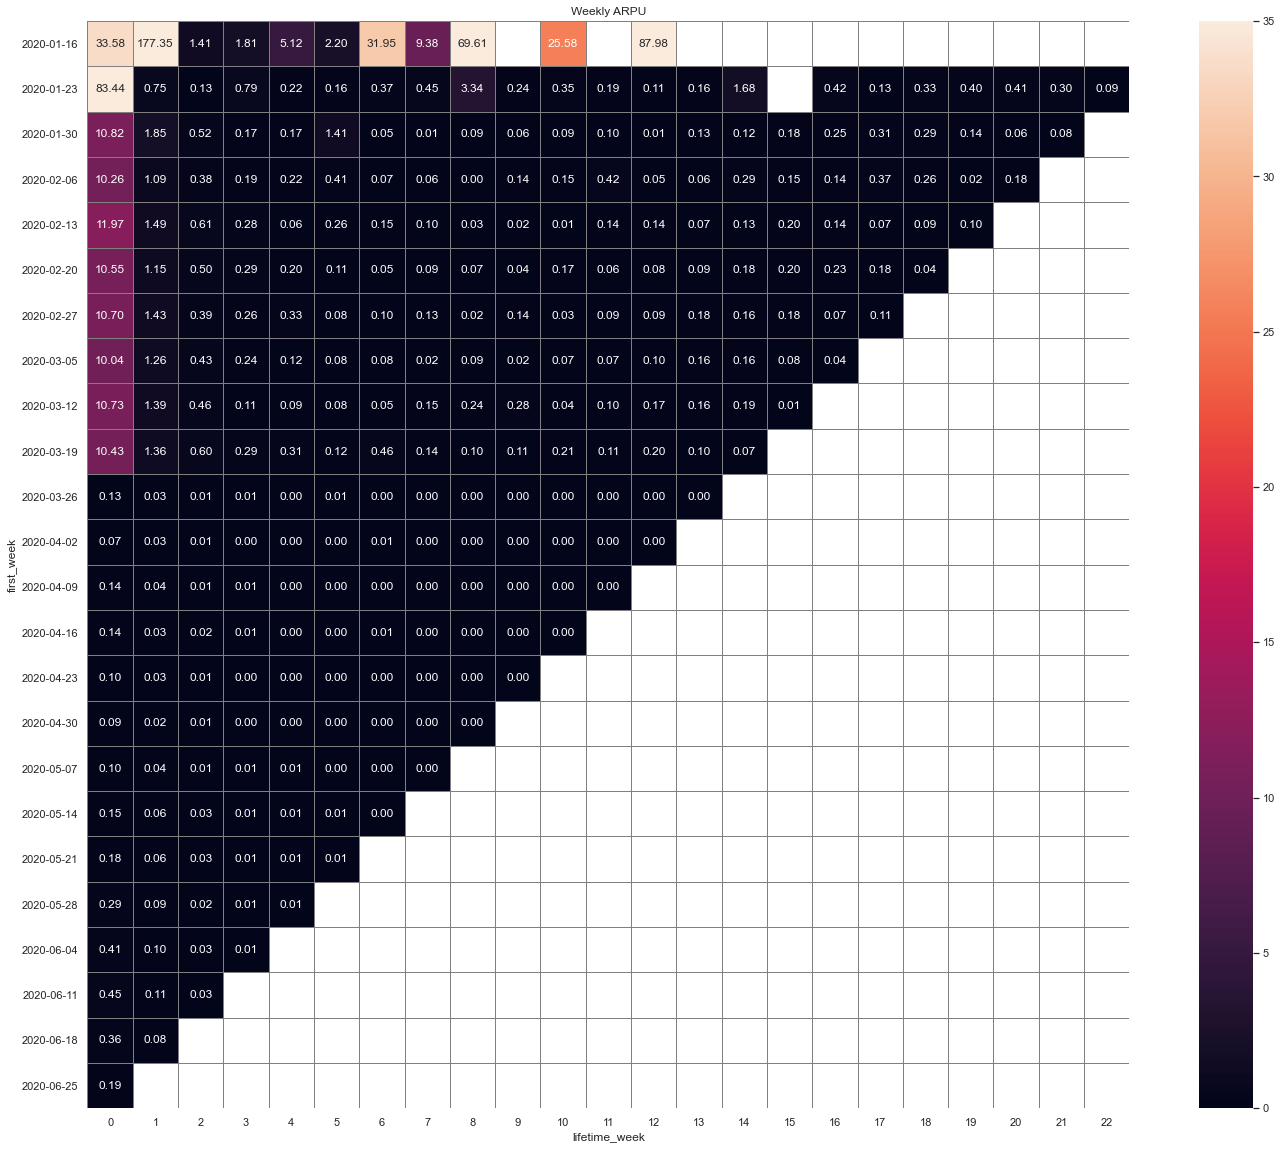

In [125]:
sns.set(style='white')
plt.figure(figsize=(25, 20))
plt.title('Weekly ARPU')
sns.heatmap(arpu_week_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray', vmin = 0.0, vmax = 35, square = True)

В разбивке по неделям так же видно, что ARPU очень низкий, пользователи не охотно совершают покупки.

## По дням <a name='день'></a>

Так как в разбивке по дням хитмэпы будут выглядеть неинформативно для восприятия, просто посчитаем суммарный ARPU для каждой дневной когорты

In [129]:
first_day = df.groupby(['user_id'])['created_day'].min()

In [130]:
first_day.head()

user_id
00000d13-a60b-d8a5-372c-6ac3338d9532   2020-05-02
000021ca-20bf-8f73-7298-88d4091c0b43   2020-04-06
00003734-81ef-7a1d-e4c9-f984bf2bc8bc   2020-05-02
00004cea-3621-30ef-db24-1e52d001449b   2020-04-03
00005b7d-52a7-2280-be8e-a932155dd075   2020-06-22
Name: created_day, dtype: datetime64[ns]

In [131]:
first_day.name = 'first_day'

In [132]:
df = df.join(first_day,on='user_id') 

In [133]:
cohorts_daily = df.groupby(['first_day']).agg({'user_id':'nunique', 'reporting_revenue' : 'sum'}).reset_index() 

In [134]:
cohorts_daily.head()

,first_day,user_id,reporting_revenue
0,2020-01-17,1,244.939858
1,2020-01-20,2,1958.639163
2,2020-01-21,1,19.545125
3,2020-01-22,1,6.675666
4,2020-01-23,12,256.861398


In [135]:
cohorts_daily['arpu'] = cohorts_daily['reporting_revenue'] / cohorts_daily['user_id']

In [136]:
cohorts_daily.head()

,first_day,user_id,reporting_revenue,arpu
0,2020-01-17,1,244.939858,244.939858
1,2020-01-20,2,1958.639163,979.319582
2,2020-01-21,1,19.545125,19.545125
3,2020-01-22,1,6.675666,6.675666
4,2020-01-23,12,256.861398,21.405117


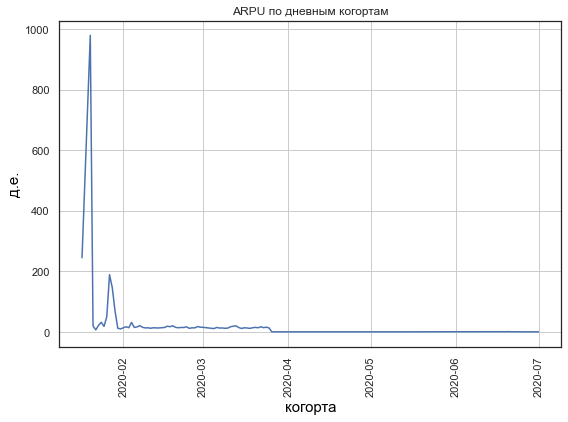

In [137]:
fig, ax = plt.subplots()
fig.set_figheight(6) 
fig.set_figwidth(9) 
ax.plot(cohorts_daily.first_day, cohorts_daily.arpu)
ax.set_xlabel('когорта', fontsize = 15, color = 'black')
ax.set_ylabel('д.е.', fontsize = 15, color = 'black')
plt.xticks(rotation=90)
ax.grid(True)
ax.set_title('ARPU по дневным когортам')
plt.show()

In [138]:
cohorts_daily.sort_values('arpu', ascending = False).head(15)

,first_day,user_id,reporting_revenue,arpu
1,2020-01-20,2,1958.639163,979.319582
0,2020-01-17,1,244.939858,244.939858
8,2020-01-27,48,9071.324651,188.985930
9,2020-01-28,50,7291.671437,145.833429
10,2020-01-29,57,3945.314458,69.216043
7,2020-01-26,28,1406.851050,50.244680
5,2020-01-24,31,983.009514,31.709984
16,2020-02-04,85,2656.038079,31.247507
4,2020-01-23,12,256.861398,21.405117
19,2020-02-07,131,2714.627469,20.722347


График отражает картину, которую мы наблюдали ранее - до февраля, а особенно в первый месяц наблюдений, люди часто совершали покупки, а затем прибыль на пользователя совсем опустилась почти к нулевой отметке.  

# Выводы: <a name='вывод'></a>

В имеющихся данных за 16.12.19-01.07.2020 были удалены дублирующиеся строки, анализ проводился на 11 196 028 записях. В первый месяц наблюдения кол-во игроков было небольшим, но все юзеры совершали покупки. Февральская когорта тоже совершала покупки в свой первый месяц, но ARPU упал засчет того, что кол-во пользователей увеличилось. В последующие недели и месяцы аудитория росла, но юзеры очень редко совершали покупки, уровень прибыли оставался примерно на одном уровне в пределах 100-110 тысяч, кол-во покупателей в пределах 6 тысяч. При этом в период с марта по апрель аудитория достигла своего пика, увеличившись многоратно до 542 тысяч человек. После чего интерес к игре снова начал убывать. При этом странно, что на спаде интереса в июне был полуторный рост выручки (150 000). 
В целом игроки не задерживаются дольше 1 недели, и , возможно, отчасти от этого так мало покупок - юзеры просто не вовлечены в процесс. Стоит работать и над удержанием, и над внутриигровой монетизацией. 